<a href="https://colab.research.google.com/github/chinhld20416c/K20416C_FDA_Final_GROUP7/blob/main/K20416C_FDA_FinalProject_Group7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 0: IMPORT LIBARARY

In [ ]:
# Import libs
!pip install squarify
import squarify

import pandas as pd
import numpy as np

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Section 1: LOAD DATESET FOR RFM MODEL AND EDA 

In [ ]:
# Load data for RFM model.
from google.colab import files
uploaded = files.upload()


Saving RFM_US_FINAL.xls to RFM_US_FINAL.xls


In [ ]:
customer = pd.read_excel("RFM_US_FINAL.xls")

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [ ]:
customer

,CustomerID,Recency,Frequency,Monetary
0,18569,357,1,4.99
1,27059,338,1,118.96
2,19897,71,1,596.96
3,27036,334,1,7.28
4,18546,291,1,29.48
...,...,...,...,...
8205,21640,193,1,123.96
8206,22722,193,1,562.96
8207,23263,167,1,23.97
8208,14607,80,1,4.99


In [ ]:
#@title Default title text
customer.describe()

,CustomerID,Recency,Frequency,Monetary
count,8210.000000,8210.000000,8210.000000,8210.000000
mean,20702.393910,207.377101,1.466626,7673.275361
std,5588.902938,172.115449,1.346497,48779.629943
min,11012.000000,1.000000,1.000000,1.374000
25%,15882.250000,92.000000,1.000000,44.047500
50%,20539.500000,178.000000,1.000000,148.470000
75%,25623.750000,278.000000,2.000000,2369.970000
max,30118.000000,1123.000000,12.000000,877107.192300


# EDA

In [ ]:
# # Load invoice dataset we get by join Sales.SalesOrderHeader and Sales.SalesOrderDetail on SalesOrderID
# The dataset have some field: SalesOrderNumbers, OrderDate, UnitPrice, OrderQty...
# We want to see what was going in the historical transaction to find out which month having number of sales well

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving RFM_US_FINAL.xls to RFM_US_FINAL (1).xls


In [ ]:
#Turn dataset into dataframe by using pandas lib
invoice_df = pd.read_excel("INVOICE_US.xls")

#View data
invoice_df

,CustomerID,SalesOrderNumber,OrderDate,OrderQty,UnitPrice,ProductID
0,29825,SO43659,2011-05-31,1,2024.994,776
1,29825,SO43659,2011-05-31,3,2024.994,777
2,29825,SO43659,2011-05-31,1,2024.994,778
3,29825,SO43659,2011-05-31,1,2039.994,771
4,29825,SO43659,2011-05-31,1,2039.994,772
...,...,...,...,...,...,...
60148,13753,SO75110,2014-06-30,1,54.990,880
60149,13753,SO75110,2014-06-30,1,7.950,877
60150,11981,SO75119,2014-06-30,1,4.990,921
60151,11981,SO75119,2014-06-30,1,35.000,930


In [ ]:
# Calculating revenue per month
# First calculating subtotal per ProductID
n_df2 = invoice_df.loc[:, ("SalesOrderNumber", "OrderDate", "OrderQty", "UnitPrice")]
n_df2["SubTotal"] = n_df2["OrderQty"] * n_df2["UnitPrice"]
n_df2

,SalesOrderNumber,OrderDate,OrderQty,UnitPrice,SubTotal
0,SO43659,2011-05-31,1,2024.994,2024.994
1,SO43659,2011-05-31,3,2024.994,6074.982
2,SO43659,2011-05-31,1,2024.994,2024.994
3,SO43659,2011-05-31,1,2039.994,2039.994
4,SO43659,2011-05-31,1,2039.994,2039.994
...,...,...,...,...,...
60148,SO75110,2014-06-30,1,54.990,54.990
60149,SO75110,2014-06-30,1,7.950,7.950
60150,SO75119,2014-06-30,1,4.990,4.990
60151,SO75119,2014-06-30,1,35.000,35.000


In [ ]:
# Secondly calculating total per SalesOrderNumber
n_df2 = n_df2.groupby(['SalesOrderNumber', 'OrderDate']).SubTotal.sum().reset_index()
n_df2.columns = ['SalesOrderNumber', 'OrderDate', 'Total']
n_df2

,SalesOrderNumber,OrderDate,Total
0,SO43659,2011-05-31,20565.6206
1,SO43660,2011-05-31,1294.2529
2,SO43663,2011-05-31,419.4589
3,SO43664,2011-05-31,24432.6088
4,SO43665,2011-05-31,14352.7713
...,...,...,...
12036,SO75106,2014-06-30,7.2800
12037,SO75107,2014-06-30,56.9700
12038,SO75109,2014-06-30,85.4800
12039,SO75110,2014-06-30,84.9200


In [ ]:
# Finaly, Calculating revenue in each month
# Sort data folowing OrderDate
n_df2 = n_df2[['OrderDate', 'Total']].sort_values('OrderDate', axis=0, ascending=True, na_position='first')
# Sum "Total" group by month
n_df3 = n_df2.groupby(pd.Grouper(key='OrderDate', axis=0, freq='M')).sum().reset_index()
n_df3

In [ ]:
# Get Year and Month from OrderDate
n_df3['Year'] = n_df3['OrderDate'].dt.year
n_df3['Month'] = n_df3['OrderDate'].dt.month
n_df3

,OrderDate,Total,Year,Month
0,2011-05-31,3.780668e+05,2011,5
1,2011-06-30,1.243936e+05,2011,6
2,2011-07-31,1.364412e+06,2011,7
3,2011-08-31,1.734817e+06,2011,8
4,2011-09-30,1.728051e+05,2011,9
5,2011-10-31,3.591470e+06,2011,10
6,2011-11-30,2.900608e+05,2011,11
7,2011-12-31,7.589413e+05,2011,12
8,2012-01-31,2.867280e+06,2012,1
9,2012-02-29,8.729269e+05,2012,2


In [ ]:
# Set OrderDate into index
n_df3 = n_df3.set_index('OrderDate')
n_df3

In [ ]:
# We want to draw line graph revenue compare among years, but we have a issue here. We cannot plot well when
# 2011, AdventureWork data has just from May, similarly, 2014 has from january to june
# So we decice add missing month with revenue = 0 into 2011 and 2014 

# Data to add more in 2011
dic1_add_2011 = {'Total': [0, 0, 0, 0], 'Year': [2011, 2011, 2011, 2011], 'Month': [1, 2, 3, 4]}
df1 = pd.DataFrame(dic1_add_2011)
# Data to add more in 2014
dic2_add_2014 = {'Total': [0, 0, 0, 0, 0, 0], 'Year': [2014, 2014, 2014, 2014, 2014, 2014], 'Month': [7, 8, 9, 10, 11, 12]}
df2 = pd.DataFrame(dic2_add_2014)
# Concanate df1 into head and df2 into tail the dataframe
n_df3 = pd.concat([df1, n_df3], ignore_index = True)
n_df3 = pd.concat([n_df3, df2], ignore_index = True)
n_df3

,Total,Year,Month
0,0.000000e+00,2011,1
1,0.000000e+00,2011,2
2,0.000000e+00,2011,3
3,0.000000e+00,2011,4
4,3.780668e+05,2011,5
5,1.243936e+05,2011,6
6,1.364412e+06,2011,7
7,1.734817e+06,2011,8
8,1.728051e+05,2011,9
9,3.591470e+06,2011,10


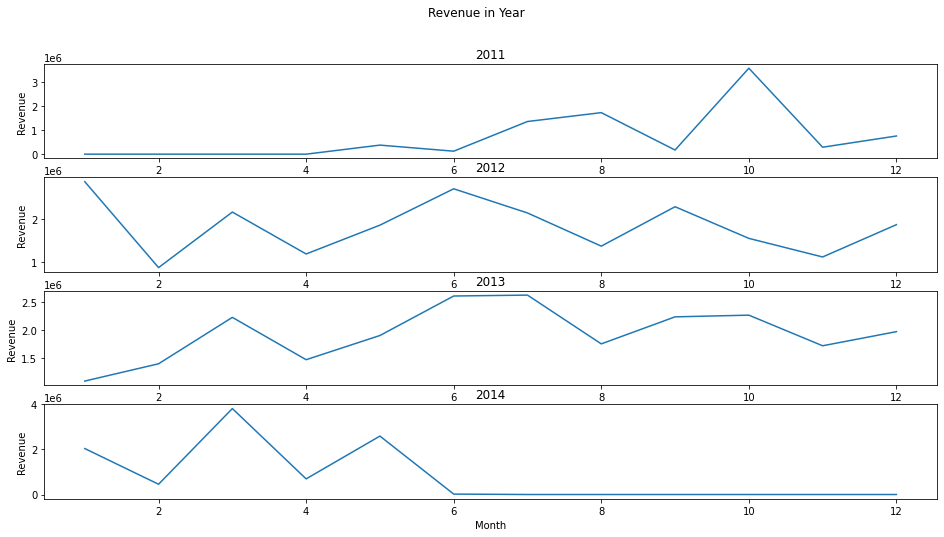

In [ ]:
# Draw line graph

# Index of subplot
i = 0
n = len(n_df3["Year"].unique())
# Set figure size to look well
plt.figure(figsize=(16, 8)) 
for name, group in n_df3.groupby('Year'):
  i = i + 1
  x = group["Month"]
  y = group["Total"]
  plt.subplot(n, 1, i)
  plt.xlabel("Month")
  plt.ylabel("Revenue")
  plt.title(name)
  plt.suptitle("Revenue in Year")
  plt.plot(x,y)

We found thing interesting that the company having good sales in nearly March. It is suite to lauch the new product in March to engage customer.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


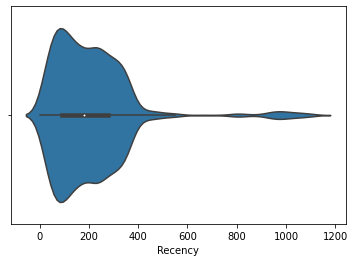

In [ ]:
sns.violinplot(customer.Recency)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


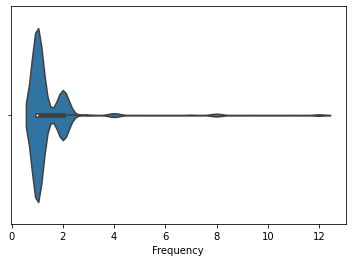

In [ ]:
sns.violinplot(customer.Frequency)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


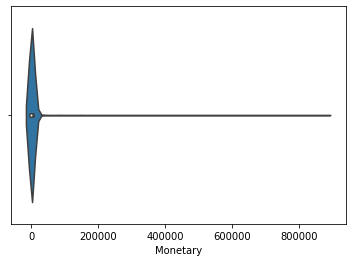

In [ ]:
sns.violinplot(customer.Monetary)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


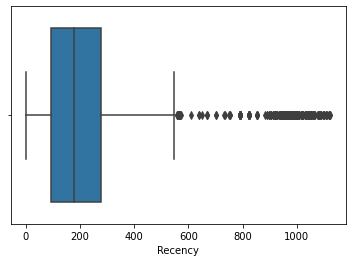

In [ ]:
sns.boxplot(customer.Recency)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


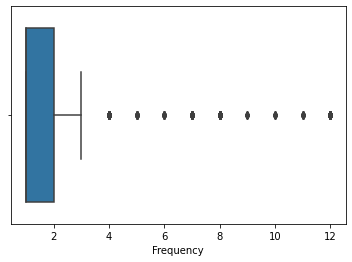

In [ ]:
sns.boxplot(customer.Frequency)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


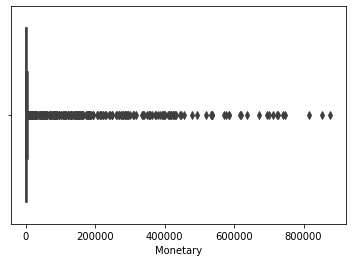

In [ ]:
sns.boxplot(customer.Monetary)

# Section 2: CLUSTERING WITH RFM

RFM Score

In [ ]:
# Load dataset
df2 = pd.read_excel('RFM_US_FINAL.xls') 

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [ ]:
# View
df2

,CustomerID,Recency,Frequency,Monetary
0,18569,357,1,4.99
1,27059,338,1,118.96
2,19897,71,1,596.96
3,27036,334,1,7.28
4,18546,291,1,29.48
...,...,...,...,...
8205,21640,193,1,123.96
8206,22722,193,1,562.96
8207,23263,167,1,23.97
8208,14607,80,1,4.99


In [ ]:
# RFM Score
df2['RecencyScore'] = pd.qcut(df2['Recency'],5,labels=[5,4,3,2,1])
df2['FrequencyScore'] = pd.qcut(df2['Frequency'].rank(method="first"),5,labels=[1,2,3,4,5])
df2['MonetaryScore'] = pd.qcut(df2['Monetary'],5,labels=[1,2,3,4,5])
df2

,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore
0,18569,357,1,4.99,1,1,1
1,27059,338,1,118.96,1,1,3
2,19897,71,1,596.96,5,1,3
3,27036,334,1,7.28,1,1,1
4,18546,291,1,29.48,2,1,1
...,...,...,...,...,...,...,...
8205,21640,193,1,123.96,3,4,3
8206,22722,193,1,562.96,3,4,3
8207,23263,167,1,23.97,3,4,1
8208,14607,80,1,4.99,4,4,1


In [ ]:
#RFM score values are combined side by side in str format
(df2['RecencyScore'].astype(str) + 
 df2['FrequencyScore'].astype(str) + 
 df2['MonetaryScore'].astype(str))

0       111
1       113
2       513
3       111
4       211
       ... 
8205    343
8206    343
8207    341
8208    441
8209    541
Length: 8210, dtype: object

In [ ]:
#calculation of the RFM score
df2["RFM_SCORE"] = df2['RecencyScore'].astype(str) + df2['FrequencyScore'].astype(str) + df2['MonetaryScore'].astype(str)
df2

,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
0,18569,357,1,4.99,1,1,1,111
1,27059,338,1,118.96,1,1,3,113
2,19897,71,1,596.96,5,1,3,513
3,27036,334,1,7.28,1,1,1,111
4,18546,291,1,29.48,2,1,1,211
...,...,...,...,...,...,...,...,...
8205,21640,193,1,123.96,3,4,3,343
8206,22722,193,1,562.96,3,4,3,343
8207,23263,167,1,23.97,3,4,1,341
8208,14607,80,1,4.99,4,4,1,441


In [ ]:
#segmenting of customers according to RecencyScore, FrequencyScore and Monetary values
# Phân các RFM_Score thành các nhóm
seg_map = {
    r'[1-2][1-5][1-3]':'Low value customers and have left the company',
    r'[1-2][1-5][4-5]':'Customers have left the company',
    r'4[1-2][1-4]':'new customer',
    r'5[1-2][5]':'new customer',
    r'4[1-2]5':'Customers spend a lot',
    r'[3-5][1-2][3-4]':'Customers spend a lot',
    r'3[3-5][3-5]':'Customers are at risk of leaving the company',
    r'[4-5]33':'Potential long-term customers',
    r'43[4-5]':'Potential long-term customers',
    r'43[4-5]':'Potential long-term customers',
    r'443':'Potential long-term customers',
    r'53[4-5]':'Potential long-term customers',
    r'543':'Potential long-term customers',
    r'[4-5][4-5][4]':'Loyal customer',
    r'[4-5]45':'Loyal customer',
    r'455':'Loyal customer',
    r'[4-5]53':'Loyal customer',
    r'555':'Best customer ',
    r'[3-5][1-5][1-2]':'General customers'
}

In [ ]:
#creation of segment variable
df2['Segment'] = df2['RecencyScore'].astype(str) + df2['FrequencyScore'].astype(str) + df2['MonetaryScore'].astype(str)
df2['Segment'] = df2['Segment'].replace(seg_map, regex=True)
df2

,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
0,18569,357,1,4.99,1,1,1,111,Low value customers and have left the company
1,27059,338,1,118.96,1,1,3,113,Low value customers and have left the company
2,19897,71,1,596.96,5,1,3,513,Customers spend a lot
3,27036,334,1,7.28,1,1,1,111,Low value customers and have left the company
4,18546,291,1,29.48,2,1,1,211,Low value customers and have left the company
...,...,...,...,...,...,...,...,...,...
8205,21640,193,1,123.96,3,4,3,343,Customers are at risk of leaving the company
8206,22722,193,1,562.96,3,4,3,343,Customers are at risk of leaving the company
8207,23263,167,1,23.97,3,4,1,341,General customers
8208,14607,80,1,4.99,4,4,1,441,General customers


In [ ]:
rfm_level_agg = df2.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(1)
rfm_level_agg

Recency Frequency Monetary      
                                                 mean      mean     mean count
Segment                                                                       
Best customer                                    57.4       4.5  74362.9   191
Customers are at risk of leaving the company    180.1       1.7   3019.9   683
Customers have left the company                 430.8       1.6  10471.9  1385
Customers spend a lot                           106.5       1.0   1099.6   590
General customers                               111.2       1.1     40.2  1714
Low value customers and have left the company   295.3       1.0    126.4  1880
Loyal customer                                   88.5       3.1  40275.3   758
Potential long-term customers                    79.1       1.1    935.2   449
new customer                                    108.2       1.0    578.8   560

RFM Segmentation Visualization

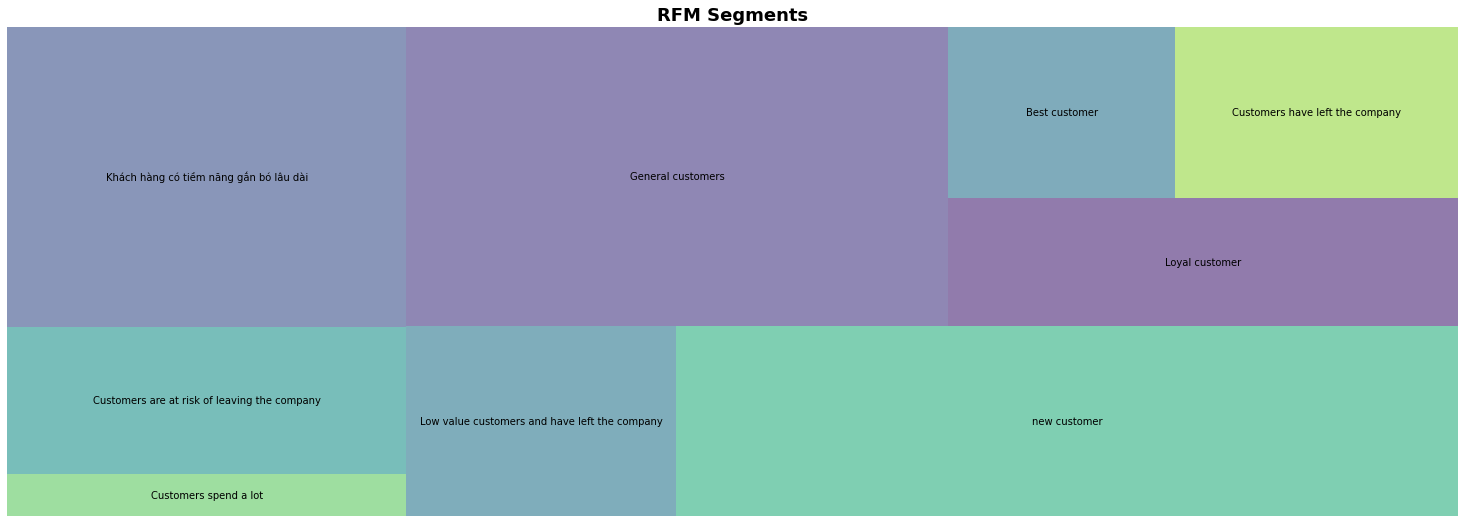

In [ ]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(26, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Customers spend a lot',
                     'Customers are at risk of leaving the company',
                     'Khách hàng có tiềm năng gắn bó lâu dài',
                     'Low value customers and have left the company',
                     'new customer',
                     'General customers',
                     'Loyal customer',
                     'Best customer',
                     'Customers have left the company'
                     ], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

# Section 3: CLUSTERING WITH K-MEANS

3D Visualization

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
def Descartes(df, title):
  fig = plt.figure(figsize = (12,12))

  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(xs = df["Recency"], ys = df["Frequency"], zs = df["Monetary"], color='red')
  ax.set_title(title)
  ax.set_xlabel("Recency")
  ax.set_ylabel("Frequency")
  ax.set_zlabel("Monetary")
  plt.show()

3D Visualization the dataset RFM

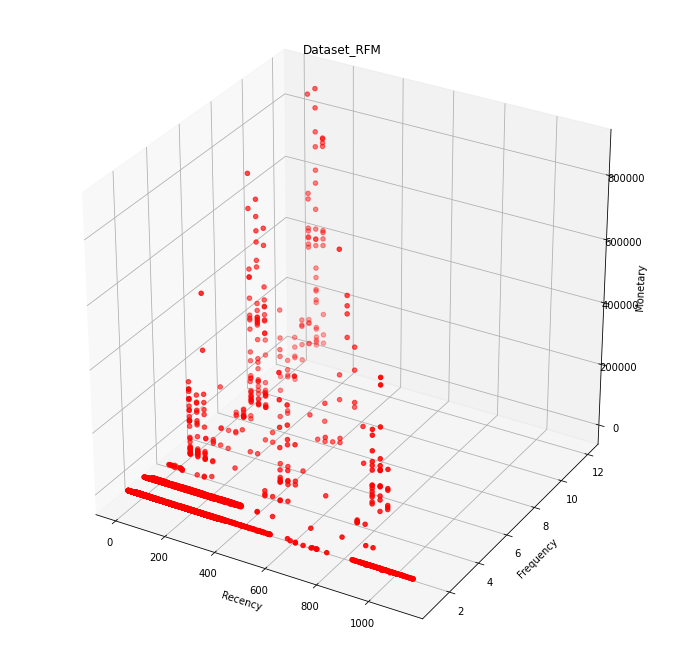

In [ ]:
Descartes(customer, 'Dataset_RFM')

Compute the z score of each value in the sample, relative to the sample mean and standard deviation.

In [ ]:
raw_dataRFM = customer.drop('CustomerID', axis=1)
# Z-Score
data_z = raw_dataRFM.apply(stats.zscore)

In [ ]:
print(type(data_z))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
data_docs = customer.drop(['Recency','Frequency','Monetary' ], axis=1)

data_docs['Recency'] = data_z['Recency']
data_docs['Frequency'] = data_z['Frequency']
data_docs['Monetary'] = data_z['Monetary']

In [ ]:
data_docs.head(10)

,CustomerID,Recency,Frequency,Monetary
0,18569,0.869370,-0.346569,-0.157212
1,27059,0.758972,-0.346569,-0.154876
2,19897,-0.792407,-0.346569,-0.145076
3,27036,0.735731,-0.346569,-0.157165
4,18546,0.485883,-0.346569,-0.156710
5,17003,-0.670388,-0.346569,-0.107773
6,21440,1.095976,-0.346569,-0.145773
7,22768,0.451021,-0.346569,-0.145004
8,15844,-0.467024,0.396144,-0.093043
9,22791,0.427779,-0.346569,-0.145004


Comparison of distribution of data before and after normalization by z-score method

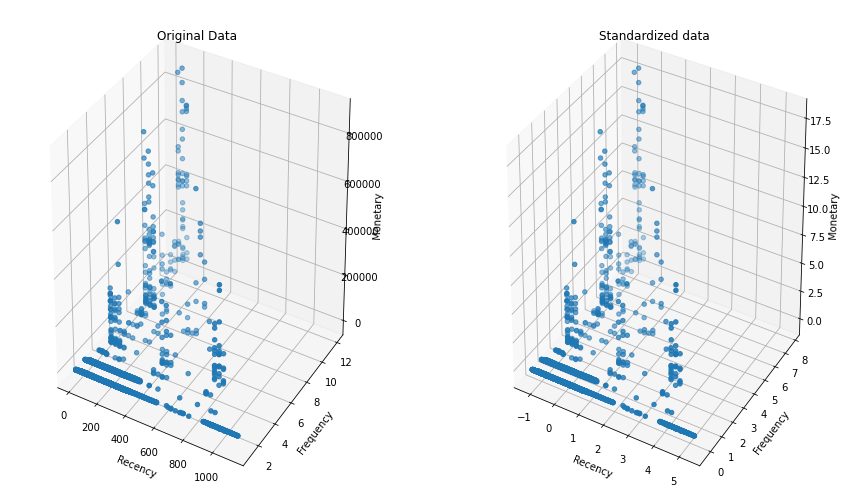

In [ ]:
fig = plt.figure(1, [15, 9])

ax = fig.add_subplot(121, projection='3d')
ax.scatter(xs = raw_dataRFM["Recency"], ys = raw_dataRFM["Frequency"], zs = raw_dataRFM["Monetary"])
ax.set_title("Original Data")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")


ax = fig.add_subplot(122, projection='3d')
ax.scatter(xs = data_z["Recency"], ys = data_z["Frequency"], zs = data_z["Monetary"])
ax.set_title("Standardized data")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

plt.show()

ASSESS CLUSTERING TENDENCY BY HOPSKINS STATISTIC

# Check clustering tendency by applying Hopkins Statistics

In [ ]:
from numpy.random import uniform
from sklearn.neighbors import NearestNeighbors
from random import sample
###################
# Source: github: https://github.com/prathmachowksey/Hopkins-Statistic-Clustering-Tendency/blob/master/Hopkins-Statistic-Clustering-Tendency.ipynb
# Algorithm: https://en.wikipedia.org/wiki/Hopkins_statistic
###################

# Function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X):
    
    X = X.to_numpy()  #convert dataframe to a numpy array, better than .values @stackoverflow
    sample_size = int(X.shape[0]*0.05) # 0.05 (5%) based on paper by Lawson and Jures
    # The shape of an array is the number of elements in each dimension
    
    # A uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0), (sample_size , X.shape[1]))
    # uniform(low, high, size), if size is a tuple eg. (r, c) meaning return ndaray.shape = (r, c) 
    
    
    # A random sample of size sample_size from the original data X
    random_indices = sample(range(0, X.shape[0], 1), sample_size)
    # shape(m, n) likes m is number of rows and n is number of columns
    # random.sample(sequence, n): Get randomly n elements from the sequence

    X_sample = X[random_indices]  # A random cordinate(R, F, M)
   
    
    # Initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)  # default: metric = "minkowski" and p = 2 that meaning
    # calculate distance by Euclidean; n_neighbors: number of nearest neighbor
    nbrs=neigh.fit(X)
    
    # u_distances = nearest neighbour distances from uniform random sample, 2 demension array distance increasing
    # u_indices: 2 demension array contains index of the nearest neighbor in the sample increasingly
    u_distances, u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] # distance to the first (nearest) neighbour in each 1-nd array distance
    
    # w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances, w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    # Distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]
    
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    # Compute and return hopkins' statistic
    H = u_sum / (u_sum + w_sum)
    return H

In [ ]:
# Measure clustering tendency by Hopkins Statistic algorithm
hopkins_score = hopkins_statistic(data_z)
hopkins_score  

0.9942107031997437

Elbow

USING ELBOW TO FIND OPTIMAL NUMBER CLUSTERS

[14404.972610184464, 9647.223046075705, 6819.196148377403, 4557.463178787987, 3864.4544975856643, 3224.3428865299793, 2757.899244772977, 2402.5481988273077, 2130.7000751477426]


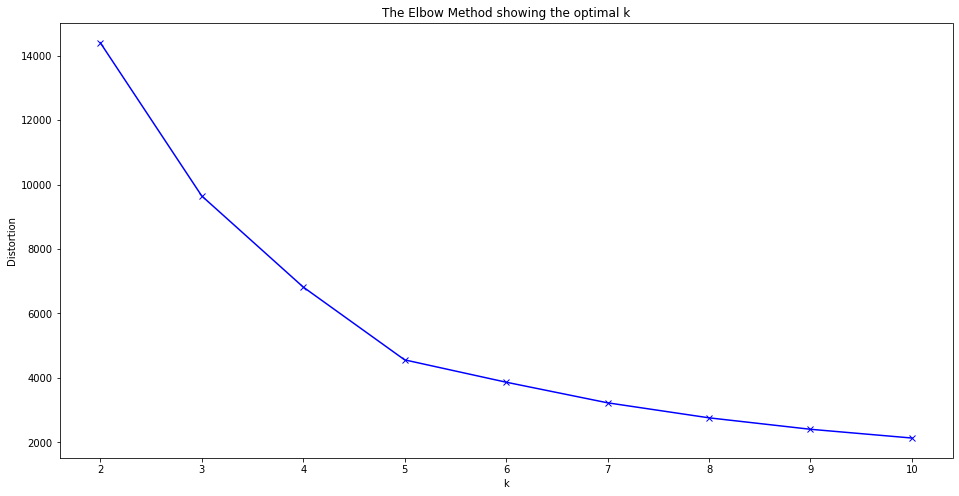

In [ ]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8, 9, 10]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(data_z)
    
    ssd.append(kmeans.inertia_)
print(ssd)
# plot the SSDs for each n_clusters
plt.figure(figsize=(16,8))
plt.plot(range_n_clusters, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Silhouette

COMBINE WITH SILHOUETTE TO FIND OUT OPTIMAL NUMBER CLUSTERS

In [ ]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit_predict(data_z)
    
    
    
    # silhouette score
    silhouette_avg = silhouette_score(data_z, kmeans.labels_, metric='euclidean')



    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.8415029608986109
For n_clusters=3, the silhouette score is 0.7783640389058721
For n_clusters=4, the silhouette score is 0.782954945768832
For n_clusters=5, the silhouette score is 0.4960755893172492
For n_clusters=6, the silhouette score is 0.4966718212536378
For n_clusters=7, the silhouette score is 0.524558584176336
For n_clusters=8, the silhouette score is 0.5273473825370888
For n_clusters=9, the silhouette score is 0.49301326524670114


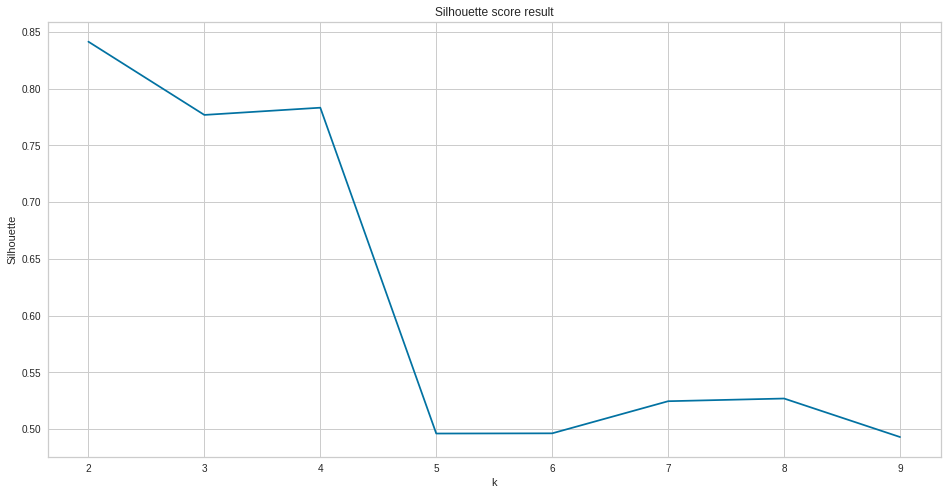

In [ ]:
from pandas.core.common import random_state
kmeans_per_k = [KMeans(n_clusters = k, random_state=42).fit(data_z) for k in range(1, 10)]

silhouette_scores = [silhouette_score(data_z, x.labels_) for x in kmeans_per_k[1:]]
range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8, 9]
plt.figure(figsize=(16,8))
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score result')
plt.show()

In [ ]:
#For n_clusters=4, the silhouette score is 0.782954945768832

IMPLEMENT K-MEANS ALGORITHM

In [ ]:
# k=4
model = KMeans(n_clusters = 4, max_iter = 300)
model.fit(data_z)

KMeans(n_clusters=4)

3D Visualization the result

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


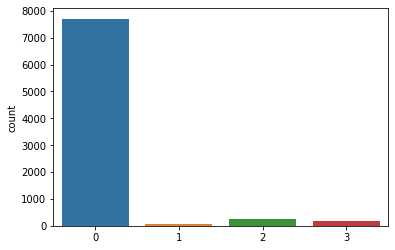

In [ ]:
import seaborn as sns

sns.countplot(model.labels_)

In [ ]:

import plotly.graph_objects as go

PLOT = go.Figure()

for C in list(customer.Cluster_Id.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = customer[customer.Cluster_Id == C]['Recency'],
                                y = customer[customer.Cluster_Id == C]['Frequency'],
                                z = customer[customer.Cluster_Id == C]['Monetary'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(C)))


PLOT.update_layout(width = 1200, height = 1200, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Recency', titlefont_color = 'black'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                zaxis=dict(title = 'Monetary', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

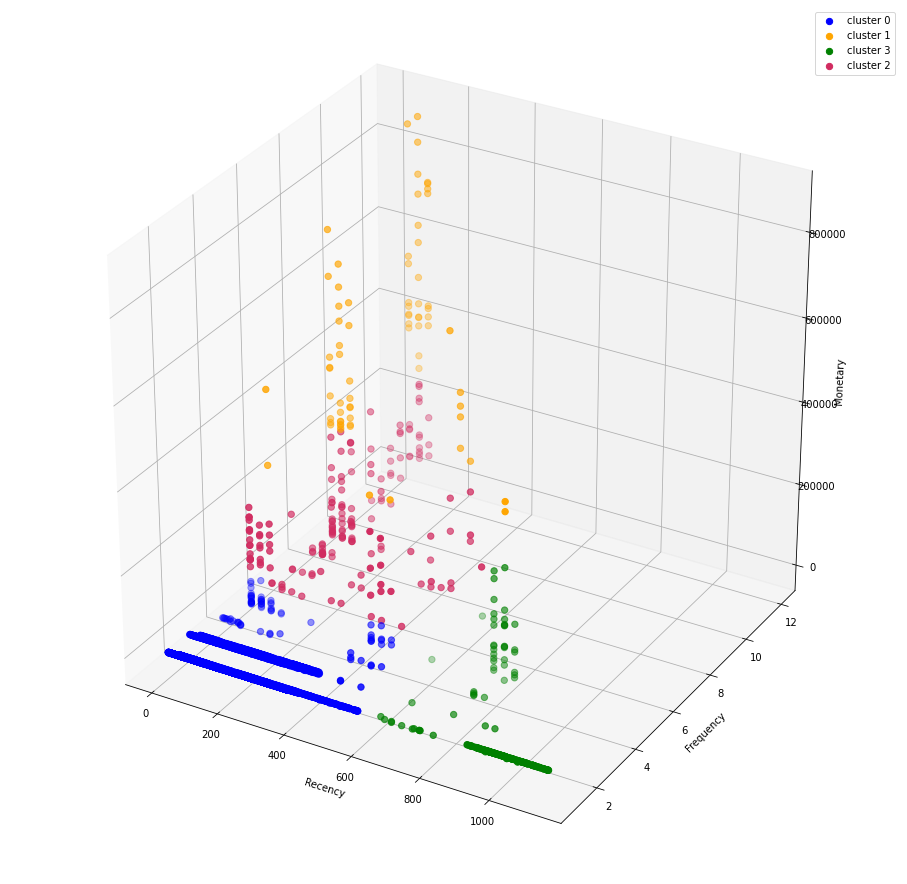

In [ ]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(111, projection='3d')
df = np.array(raw_dataRFM)
ax.scatter(df[model.labels_ == 0,0],df[model.labels_ == 0,1],df[model.labels_ == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(df[model.labels_ == 1,0],df[model.labels_ == 1,1],df[model.labels_ == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(df[model.labels_ == 2,0],df[model.labels_ == 2,1],df[model.labels_ == 2,2], s = 40 , color = 'green', label = "cluster 3")
ax.scatter(df[model.labels_ == 3,0],df[model.labels_ == 3,1],df[model.labels_ == 3,2], s = 40 , color = '#D12B60', label = "cluster 2")

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.legend()
plt.show()

In [ ]:
# assign the label
customer['Cluster_Id'] = model.labels_
customer.head(10)

,CustomerID,Recency,Frequency,Monetary,Cluster_Id
0,18569,357,1,4.99,0
1,27059,338,1,118.96,0
2,19897,71,1,596.96,0
3,27036,334,1,7.28,0
4,18546,291,1,29.48,0
5,17003,92,1,2416.45,0
6,21440,396,1,562.96,0
7,22768,285,1,600.46,0
8,15844,127,2,3134.95,0
9,22791,281,1,600.46,0


In [ ]:

x

0    7706
3     248
2     182
1      74
Name: Cluster_Id, dtype: int64

In [ ]:
x[1]

74

In [ ]:
x = customer['Cluster_Id'].value_counts()

result_des = customer.groupby('Cluster_Id').mean().round(0)


a = result_des.drop('CustomerID', 1)

a['Customer'] = [x[0] , x[1] , x[2] , x[3]]
a.columns = ["Mean Recency", 'Mean Frequency', 'Mean Monetary', 'Number of customers']
a

,Mean Recency,Mean Frequency,Mean Monetary,Number of customers
Cluster_Id,,,,
0,185.0,1.0,1254.0,7706
1,151.0,9.0,454370.0,74
2,148.0,7.0,85126.0,182
3,953.0,1.0,17001.0,248


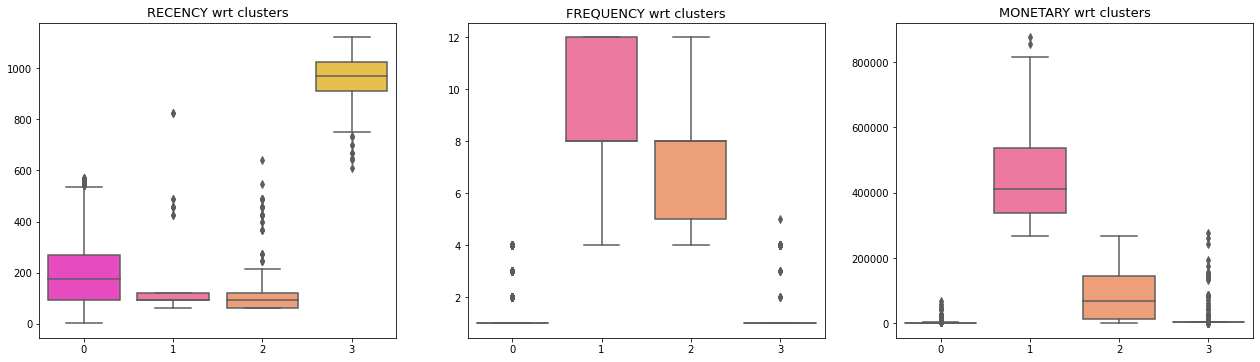

In [ ]:
column = ['Recency','Frequency','Monetary']
plt.figure(figsize=(15*1.45,4*1.45))
for i,j in enumerate(column):
    plt.subplot(1,3,i+1)
    sns.boxplot(y=customer[j], x=customer['Cluster_Id'], palette='spring')
    plt.title('{} wrt clusters'.format(j.upper()), size=13)
    plt.ylabel('')
    plt.xlabel('')

plt.show()